In [1]:
import os
import cdflib

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime

# resample
from scipy.interpolate import RegularGridInterpolator

from pysemp import pysemp as SEMP
from pysemp import psp_dataprep
%load_ext autoreload
%autoreload 2
# TODO - move all demo data to google drive [done]

In [2]:
fname_ste = '../../SEMPdemo/20190409/stereo_level2_swaves_20190409_v01.cdf'
cdf_dataset = cdflib.CDF(fname_ste)

In [31]:
time_ste = cdflib.cdfepoch.to_datetime(np.array(cdf_dataset.varget('Epoch')))
freq_ste = np.array(cdf_dataset.varget('frequency'))
data_ste_A = np.array(cdf_dataset.varget('avg_intens_ahead'))

In [32]:
freq_ste_select = np.array([	725.888319695363,	879.026793283920,	1064.47242963668,	1289.04097362438,	1560.98606729497,	1890.30259871247,	2289.09404738711,	2772.01732746500,	3356.82147814644,	4065.00000000000])
t_ste_select_ste = np.array([       	2829.36985233443,	2766.65329947513,	2712.49039221413,	2696.10416516363,	2671.71582505838,	2666.16217946008,	2663.16217946008,	2659.71582505838,	2656.88324360618,	2659.88324360618])+20
freq_wi_select = np.array([	419.276728798999,	521.640876297891,	648.996677216686,	807.445708679027,	1004.57921488941,	1249.84180130059,	1554.98392274647,	1934.62484410734,	2406.95304477923,	2994.59762310928,	3725.71244951489,	4635.32500972791,	5767.01456082762,	7175.00000000000])
t_ste_select_wi = np.array([	2996.13117080708,	2894.97488788763,	2830.81409368138,	2775.20694507343,	2758.09754082208,	2712.32297366633,	2699.93674661583,	2694.54840651058,	2689.27158371143,	2665.05277520873,	2663.94125790263,	2659.11078950518,	2661.49701655568,	2660.22019375653])+20

In [34]:
dt_anchor = datetime.datetime(2019,4,9,12,0,0)
anchor_time = mdates.date2num(dt_anchor)

sec_all = (mdates.date2num(time_ste)-anchor_time)*3600*24

dyspec = data_ste_A.T
dyspec[np.isnan(dyspec)]=1e-30
dyspec_const_backsub = dyspec-np.tile(np.mean(dyspec,1).T,(dyspec.shape[1],1)).T

freq_ste_idx_mono = np.argsort(freq_ste)
freq_ste_mono = freq_ste[freq_ste_idx_mono]
dyspec_const_backsub_mono = dyspec_const_backsub[freq_ste_idx_mono,:]

f = RegularGridInterpolator((freq_ste_mono,sec_all),dyspec_const_backsub_mono)

rebin_freq_all=np.logspace(2.5,4.2,200)
rebin_t_all=sec_all
mesh_t,mesh_freq=np.meshgrid(rebin_t_all,rebin_freq_all)
rebin_data_all=f((mesh_freq,mesh_t))

In [35]:
rebin_data_all.shape

(200, 1440)

In [36]:
idx_range = np.arange(750,790)
arr_x = np.log10(rebin_data_all[0,idx_range])
N_arr_x=arr_x.ravel().shape[0]
idx_x = np.arange(N_arr_x)
x0 = rebin_t_all[idx_range]

/tmp/ipykernel_2543781/208510161.py:2: RuntimeWarning: invalid value encountered in log10
  arr_x = np.log10(rebin_data_all[0,idx_range])


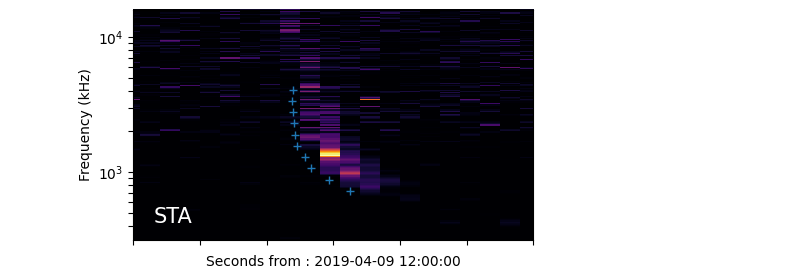

In [39]:
from matplotlib.image import NonUniformImage
fig = plt.figure(figsize=(5,2.5)) 
ax = fig.add_axes([0.15,0.05,0.8,0.92])

im = NonUniformImage(ax, interpolation='nearest',extent=[x0[0],x0[-1],rebin_freq_all[0],rebin_freq_all[-1]],cmap='inferno')
lin_freq = np.linspace(rebin_freq_all[0],rebin_freq_all[-1],rebin_freq_all.shape[0])
im.set_data(x0,lin_freq,rebin_data_all[:,idx_range])
ax.add_image(im)
im.set_clim([0,2])
ax.set_yscale('log')
ax.set_ylabel('Frequency (kHz)')
ax.set_xlim([2200,3400])
ax.set_ylim([rebin_freq_all[0],rebin_freq_all[-1]])
ax.set_aspect('auto', 'datalim')
ax.set_xlabel('Seconds from : '+str(dt_anchor))
ax.plot(t_ste_select_ste,freq_ste_select,'C0+')
ax.text(0.1, 0.1,'STA',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
     fontsize=15)
ax.xaxis.set_ticklabels([]) 
ax.yaxis.set_major_locator(plt.LogLocator(base=10,subs='all'))
#fig.savefig('img/STA.pdf')

In [40]:
# save the data to npz
# np.savez('tmpData/WI_STA_LE.npz',freq_STA = freq_ste_select, t_STA = t_ste_select_ste,
#                 freq_WI = freq_wi_select, t_WI = t_ste_select_wi)
# np.savez('tmpData/STA_data.npz',
#     ds_t_STA = x0,ds_f_STA = rebin_freq_all,data_STA=rebin_data_all[idx_range,:])

In [42]:
fname_ste = '../../SEMPdemo/20190409/wi_h1_wav_20190409_v01.cdf'
cdf_dataset = cdflib.CDF(fname_ste)

In [62]:
time_wi = cdflib.cdfepoch.to_datetime(np.array(cdf_dataset.varget('Epoch')))
freq_wi1 = np.array(cdf_dataset.varget('Frequency_RAD1'))
freq_wi2 = np.array(cdf_dataset.varget('Frequency_RAD2'))
data_wi1 = np.array(cdf_dataset.varget('E_VOLTAGE_RAD1'))
data_wi2 = np.array(cdf_dataset.varget('E_VOLTAGE_RAD2'))

In [63]:
data_wi = np.concatenate((data_wi1,data_wi2),1)
freq_wi = np.concatenate((freq_wi1,freq_wi2))

In [64]:
dt_anchor = datetime.datetime(2019,4,9,12,0,0)
anchor_time = mdates.date2num(dt_anchor)

sec_all = (mdates.date2num(time_wi)-anchor_time)*3600*24

dyspec = data_wi.T
dyspec[np.isnan(dyspec)]=1e-30
dyspec_const_backsub = dyspec-np.tile(np.mean(dyspec,1).T,(dyspec.shape[1],1)).T

freq_wi_idx_mono = np.argsort(freq_wi)
freq_wi_mono = freq_wi[freq_wi_idx_mono]
dyspec_const_backsub_mono = dyspec_const_backsub[freq_wi_idx_mono,:]

f = RegularGridInterpolator((freq_wi_mono,sec_all),dyspec_const_backsub_mono)


rebin_freq_all=np.logspace(1.5,4.1,200)
rebin_t_all=sec_all
mesh_t,mesh_freq=np.meshgrid(rebin_t_all,rebin_freq_all)
rebin_data_all=f((mesh_freq,mesh_t)).T

In [65]:
idx_range = np.arange(750,790)
arr_x = np.log10(rebin_data_all[idx_range,0])
N_arr_x=arr_x.ravel().shape[0]
idx_x = np.arange(N_arr_x)
x0 = rebin_t_all[idx_range]

/tmp/ipykernel_2543781/459520590.py:2: RuntimeWarning: invalid value encountered in log10
  arr_x = np.log10(rebin_data_all[idx_range,0])


[Text(2200.0, 0, ''),
 Text(2400.0, 0, ''),
 Text(2600.0, 0, ''),
 Text(2800.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3200.0, 0, ''),
 Text(3400.0, 0, '')]

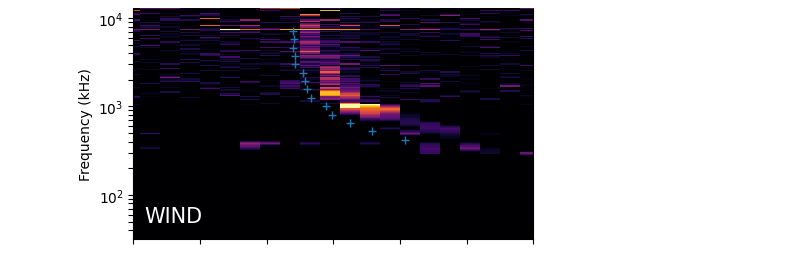

In [66]:
from matplotlib.image import NonUniformImage
fig = plt.figure(figsize=(5,2.5)) 
ax = fig.add_axes([0.15,0.05,0.8,0.92])

im = NonUniformImage(ax, interpolation='nearest',extent=[x0[0],x0[-1],rebin_freq_all[0],rebin_freq_all[-1]],cmap='inferno')
lin_freq = np.linspace(rebin_freq_all[0],rebin_freq_all[-1],rebin_freq_all.shape[0])
im.set_data(x0,lin_freq,(rebin_data_all[idx_range,:].T))
ax.add_image(im)
im.set_clim([0,0.1])
ax.set_yscale('log')
ax.set_xlim([2200,3400])
ax.set_ylim([rebin_freq_all[0],rebin_freq_all[-1]])
ax.set_aspect('auto', 'datalim')
ax.set_ylabel('Frequency (kHz)')
#ax.set_xlabel('Seconds from : '+str(dt_anchor))
ax.plot(t_ste_select_wi,freq_wi_select,'C0+')
ax.yaxis.set_major_locator(plt.LogLocator(base=10,subs='all'))
ax.text(0.1, 0.1,'WIND',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
     fontsize=15)
ax.xaxis.set_ticklabels([]) 
#fig.savefig('img/WI.pdf')

In [17]:
#np.savez('tmpData/WI_data.npsz',
#ds_t_WI = x0,ds_f_WI = rebin_freq_all,data_WI=rebin_data_all[idx_range,:])